In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan
import os

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

import itertools
colours = itertools.cycle(('r', 'b', 'g', 'orange', 'purple', 'k'))

In [2]:
#Import output data
output = pd.read_csv('../data/output_back_filesremoved.csv', usecols=[1,11,24])
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]
df_met = pd.read_csv('../data/APOKASCfull.csv')
df_class = pd.read_csv('../data/RGclassification.txt', header=None, delim_whitespace=True, names=['KIC', 'type'])

#Set numax range so stars are chosen with similar size echelles
rng = 30
numax_tgt = 75
output = output.loc[(np.abs(output['numax'] - numax_tgt) < rng)].reset_index(drop=True)

#Number of stars to model (between 1 and 1212) and star classification (RGB, RC, 2CL)
nStars = 5
RGclass = 'RGB'

#Selects a random sample of stars from the file, recording their IDs and makes sure the stars exist in APOKASC fil
IDs = []*nStars
i = 0
while i < nStars:
    nextID = random.choice(output['kic'])
    if df_class.loc[df_class['KIC'] == nextID].type.values == RGclass:
        for j in range(len(df_met.KIC)):
            if nextID == df_met.KIC[j]:
                IDs.append(nextID)
                i += 1

#Chooses specific stars each time
#IDs = [8759811, 10416550, 8824452, 11821439, 9470276]

# Create a list of the numax values and errors corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

print(IDs)

[9835626, 6850177, 9581445, 9335518, 5023889]


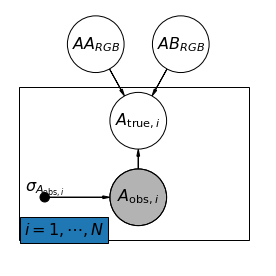

In [3]:
#Create acyclic graph (probabalistic graphical model)
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [4]:
#Import mode data and construct arrays for storing orders and frequencies
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0']) for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])

#Sort values by frequency and assign order and calculate avg dnu
dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    #(due to some stars having fewer mode frequencies observed)
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

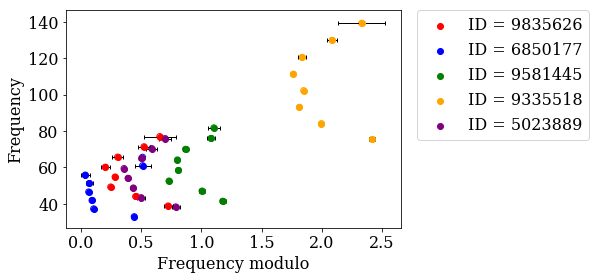

In [5]:
#Construct and plot echelles for each star
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)

#for i in np.arange(0,len(IDs),1):
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
numax_err = Numax_err
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
#A = np.ones([len(IDs)])*0.05 
A = 0.6*dnu_avgarr**(-0.88)
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*1000
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Frequency modulo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#print(A)

In [6]:
code = '''
functions{
    real asex(real n, real dnu, real nmax, real epsilon, real alpha, real A, real G, real phi, real tau){
        return (n + epsilon + (alpha/2) * (nmax - n)^2 + 
                A*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi) * exp(-(n-nmax)/tau))*dnu;
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
    real numax_obs[N];
    real numax_err[N];
}
parameters {
    real dnu[N];
    real<lower = 0> numax[N];
    real <lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];  
    
    //Hierarchical parameters
    real epsilon_std[N];
    real<lower = 0> eps_sig;
    real epsA;
    real epsB;
    
    real alpha_std[N];
    real<lower = 0> al_sig;
    real alA;
    real alB;
    
    //real <lower = 0> A[N];
    real A_std[N];
    real<lower = 0> A_sig;
    real AA;
    real AB;
    
    //real G_std[N];
    //real<lower = 0> G_sig;
    //real GA;
    //real GB;
      
}

transformed parameters{
    real epsilon[N];
    real alpha[N];
    real A[N];
    //real G[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        A[i] = A_std[i] * A_sig + (AA*dnu[i]^(-AB));
        //G[i] = G_std[i] * G_sig + (GA*dnu[i]^(-GB));
    }
}
model {
    real mod[M];
    real nmax[N];
    for (i in 1:N){
        nmax[i] = numax[i]/dnu[i] - epsilon[i];
        for (j in 1:M){
            mod[j] = asex(n[i,j], dnu[i], nmax[i], epsilon[i], alpha[i], A[i], G[i], phi[i], tau[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
        //epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        //alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        //A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-0.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.4);
    }
    //nmax ~ normal(10, 4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(50, 10);
    //numax ~ normal(numax_obs, numax_err);
    
    //Hyperpriors
    epsilon_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    
    alpha_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5); 
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    
    A_std ~ student_t(8, 0, 1);
    A_sig ~ normal(0, 0.5);
    AA ~ normal(0.06, 0.02);
    AB ~ normal(0.88, 0.05);
    
    //G_std ~ normal(0, 1);
    //G_sig ~ normal(0, 0.5);
    //GA ~ normal(0.75, 0.1);
    //GB ~ normal(0.75, 0.1);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_45444bc63da47e92913505c0666c8e6d NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmprfchagsa/stanfit4anon_model_45444bc63da47e92913505c0666c8e6d_4972476329105105767.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
no_tau = pd.read_csv('../Dan_notebooks/no_tau_models.csv', names=['dnu', 'numax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'tau'])

stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'numax_obs': numax_obs,
         'numax_err': numax_err
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'numax': numax_obs,
         'epsilon': epsilon, #no_tau['epsilon'],
         'alpha': alpha, #no_tau['alpha'],
         'A': A, #no_tau['A'],
         'eps_sig': 0.01,
         'al_sig': 0.01,
         #'A_sig': 0.01,
         'G': G,
         'tau': tau,
         'phi': phi, #no_tau['phi'],
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         #'AA': 0.06,
         #'AB': 0.88
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [8]:
print(fit)

Inference for Stan model: anon_model_45444bc63da47e92913505c0666c8e6d.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]           5.44  1.5e-4 4.6e-3   5.43   5.44   5.44   5.45   5.45    978    1.0
dnu[2]           4.64  1.3e-4 4.1e-3   4.63   4.64   4.64   4.64   4.65   1026    1.0
dnu[3]           5.77  1.3e-4 3.9e-3   5.76   5.77   5.77   5.77   5.78    864    1.0
dnu[4]            9.1  3.1e-3 6.6e-3   9.09    9.1    9.1   9.11   9.12      5   1.34
dnu[5]           5.36  1.2e-4 3.9e-3   5.35   5.36   5.36   5.36   5.37   1032    1.0
numax[1]        55.79  9.4e-3   0.28  55.24   55.6  55.79  55.98  56.35    874    1.0
numax[2]        45.76  8.3e-3   0.24  45.27  45.61  45.76  45.91  46.22    824    1.0
numax[3]        61.18  8.5e-3   0.24  60.72  61.02  61.18  61.35  61.65    794    1.0
numax[4]        103.7    0.73   1.05

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


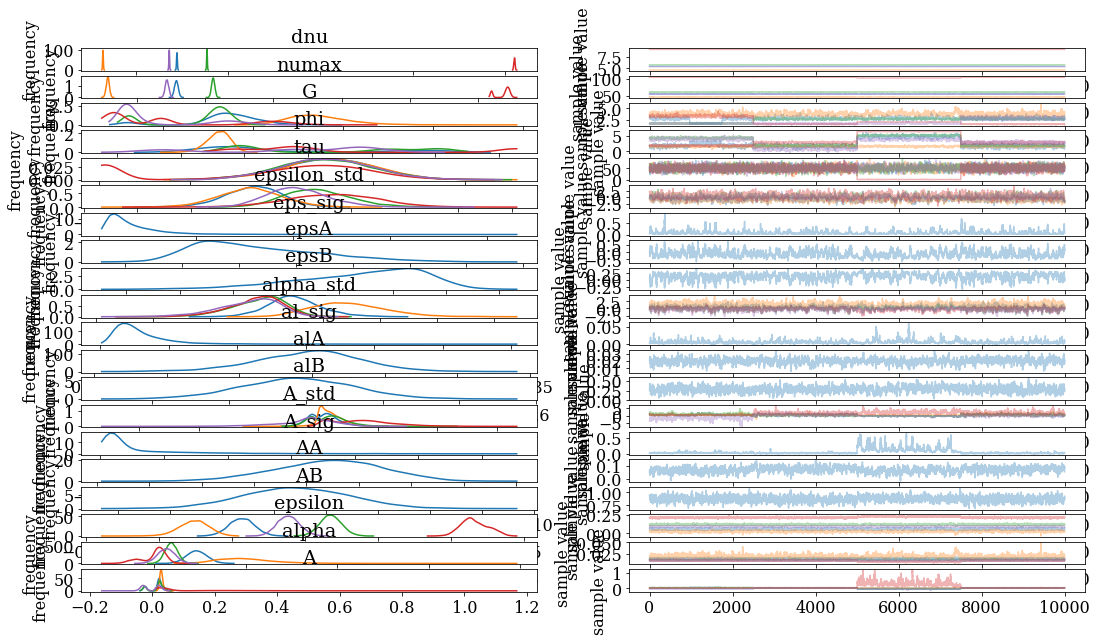

In [9]:
fig = fit.plot()
fig.set_size_inches(18, 10)
fig.show()

In [10]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi, tau):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi) * np.exp(-(n-nmax)/tau)) * dnu
    return freqs

In [11]:
#for i in range(len(IDs)):
    #print(np.mean(modesID[i]['dnu']))

#for i in range(len(IDs)):
    #print(np.mean(fit['G'], axis=0)[i])

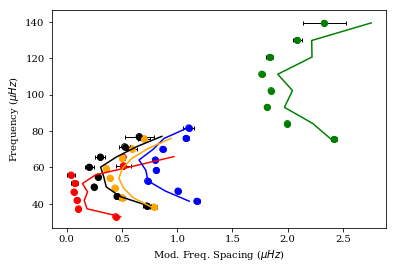

In [12]:
%matplotlib inline
    
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i])
    plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D', c=colour)


#Plot stan fitted model on echelle
#for i in range(len(IDs)):
    #plt.figure(len(IDs))
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    #g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          #np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    #plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Mod. Freq. Spacing ($\mu Hz$)')
#plt.xlim(-1,5)
plt.show()



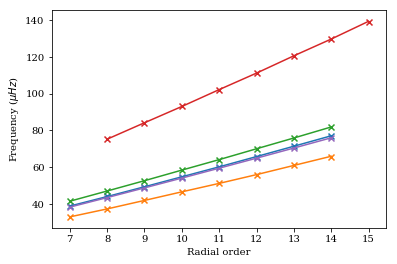

In [13]:
#Plot stan fitted model for freq vs n
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(arr_n[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Radial order')
plt.show()

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

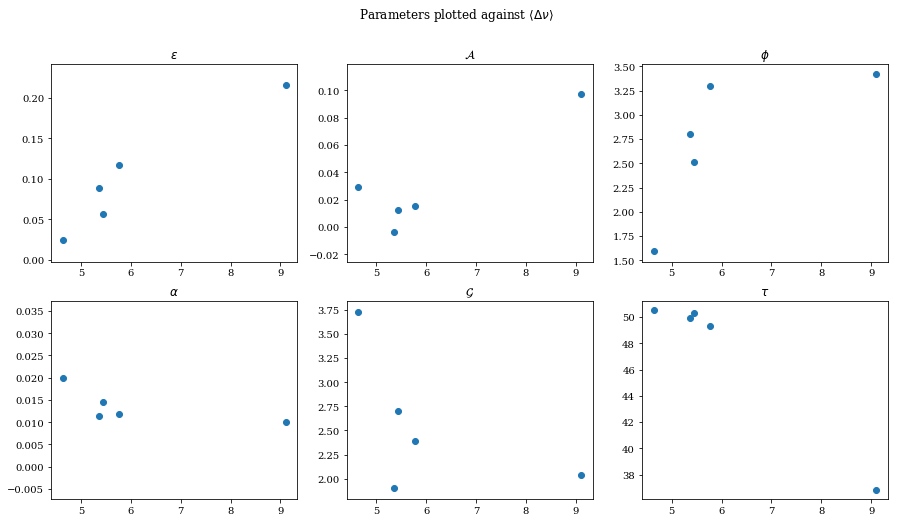

In [14]:
#Plot stan deduced parameters against dnu
dnus = []
numaxs = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(np.mean(fit['dnu'],axis=0)[i])
    numaxs.append(np.mean(fit['dnu'],axis=0)[i])
    epsilons.append(np.mean(fit['epsilon'],axis=0)[i])
    alphas.append(np.mean(fit['alpha'],axis=0)[i])
    As.append(np.mean(fit['A'],axis=0)[i])
    Gs.append(np.mean(fit['G'],axis=0)[i])
    phis.append(np.mean(fit['phi'],axis=0)[i])
    taus.append(np.mean(fit['tau'],axis=0)[i])
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

Text(0.5, 1.0, 'Period vs frequency of max power ($\\nu_{max}$)')

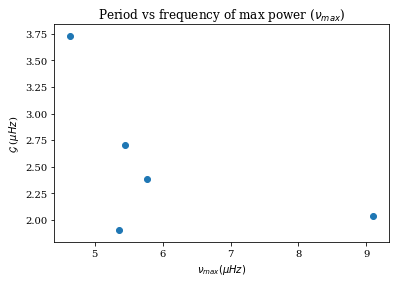

In [15]:
plt.scatter(numaxs, Gs)
plt.xlabel(r'$\nu_{max} (\mu Hz)$')
plt.ylabel(r'$\mathcal{G}$ ($\mu Hz$)')
plt.title(r'Period vs frequency of max power ($\nu_{max}$)')

Text(0, 0.5, 'Glitch amplitude ($\\mu Hz$)')

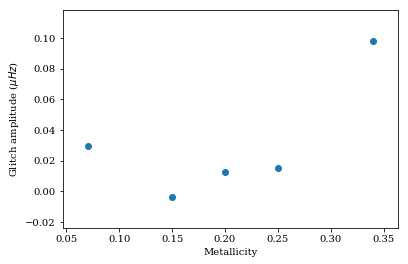

In [16]:
#Plot glitch amplitude against metallicity from APOKASC catalogue
df_met = pd.read_csv('../data/APOKASCfull.csv')
#metals = [(df_met.loc[(df_met['KIC'] == IDs[i])]).loc['[M/H]2'] for i in range(len(IDs))]


#metals = df_met.loc[(df_met['KIC'].isin(IDs))].reset_index(drop=True)

frames = []
for i in range(len(IDs)):
    mets = df_met.loc[df_met['KIC'] == IDs[i]]
    frames.append(mets)

metsall = pd.concat(frames).reset_index(drop=True)

IDdf = pd.DataFrame(IDs)
#ind = IDdf[~IDdf.isin(metsall['KIC'])]

plt.scatter(metsall['[M/H]2'].values, As)
plt.xlabel('Metallicity')
plt.ylabel('Glitch amplitude ($\mu Hz$)')

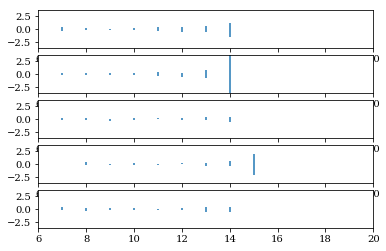

In [17]:
fig, ax = plt.subplots(nStars)
for i in range(nStars):
    g = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i],
              np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
              np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i],
              np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i])
    ax[i].errorbar(arr_n[i, :], arr_freq[i,:] - g, yerr=arr_freqerr[i, :]*10, linestyle='none')
    ax[i].set_xlim([6,20])
    ax[i].set_ylim([-3.5, 3.5])